In [1]:
import os
import glob
import matplotlib.pyplot as plt
import datetime as dt
import arcticdb as adb
import pandas as pd

In [2]:
adb.__version__

'5.4.0'

In [3]:
arctic = adb.Arctic("lmdb://equity_options")
lib = arctic.get_library("options", create_if_missing=True)

In [4]:
def read_chains(file):
    df = (
        pd.read_csv(file)
        .set_index("date")
    )
    df.index = pd.to_datetime(df.index)
    return df

In [5]:
files = glob.glob(os.path.join("rut-eod", "*.csv"))
for file in files:
    chains = read_chains(file)
    chains.option_expiration = pd.to_datetime(chains.option_expiration)
    underlyings = chains.symbol.unique()
    for underlying in underlyings:
        df = chains[chains.symbol == underlying]
        adb_sym = f"options/{underlying}"
        adb_fcn = lib.update if lib.has_symbol(adb_sym) else lib.write
        adb_fcn(adb_sym, df)

In [6]:
rut = lib.read("options/RUT").data

In [7]:
rut

,symbol,exchange,company_name,stock_price_close,option_symbol,option_expiration,strike,call_put,style,open,...,volume,open_interest,stock_price_for_iv,forward_price,isinterpolated,delta,vega,gamma,theta,rho
date,,,,,,,,,,,,,,,,,,,,,
2006-07-28,RUT,CBOE,CBOE RUSSELL 2000 INDEX,700.03,RUWHZ,2006-08-18,500.0,C,E,0.0,...,0,10,700.03,702.341,*,0.999997,0.000020,0.000000,-0.074688,0.286767
2006-07-28,RUT,CBOE,CBOE RUSSELL 2000 INDEX,700.03,RUWTZ,2006-08-18,500.0,P,E,0.0,...,0,12,700.03,702.341,*,-0.000015,0.000112,0.000001,-0.000090,-0.000006
2006-07-28,RUT,CBOE,CBOE RUSSELL 2000 INDEX,700.03,RUWHB,2006-08-18,510.0,C,E,0.0,...,0,10,700.03,702.341,*,0.999991,0.000065,0.000001,-0.076214,0.292499
2006-07-28,RUT,CBOE,CBOE RUSSELL 2000 INDEX,700.03,RUWTB,2006-08-18,510.0,P,E,0.0,...,0,139,700.03,702.341,*,-0.000042,0.000296,0.000003,-0.000237,-0.000017
2006-07-28,RUT,CBOE,CBOE RUSSELL 2000 INDEX,700.03,RUWHD,2006-08-18,520.0,C,E,0.0,...,0,11,700.03,702.341,*,0.999973,0.000192,0.000002,-0.077800,0.298227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-04,RUT,CBOE,CBOE RUSSELL 2000 INDEX,1167.21,RUT 161216P01400000,2016-12-16,1400.0,P,E,0.0,...,0,0,1167.21,1148.090,NaN,-0.698734,5.772437,0.001017,-0.074491,-25.389023
2014-09-04,RUT,CBOE,CBOE RUSSELL 2000 INDEX,1167.21,RUT 161216C01450000,2016-12-16,1450.0,C,E,0.0,...,0,0,1167.21,1148.090,NaN,0.221706,5.180473,0.000946,-0.049035,5.105982
2014-09-04,RUT,CBOE,CBOE RUSSELL 2000 INDEX,1167.21,RUT 161216P01450000,2016-12-16,1450.0,P,E,0.0,...,0,0,1167.21,1148.090,NaN,-0.745931,5.226550,0.000943,-0.067647,-27.521128


In [8]:
rut.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2370886 entries, 2006-07-28 to 2014-09-04
Data columns (total 28 columns):
 #   Column              Dtype         
---  ------              -----         
 0   symbol              object        
 1   exchange            object        
 2   company_name        object        
 3   stock_price_close   float64       
 4   option_symbol       object        
 5   option_expiration   datetime64[ns]
 6   strike              float64       
 7   call_put            object        
 8   style               object        
 9   open                float64       
 10  high                float64       
 11  low                 float64       
 12  close               float64       
 13  bid                 float64       
 14  ask                 float64       
 15  mean_price          float64       
 16  settlement          float64       
 17  iv                  float64       
 18  volume              int64         
 19  open_interest       int64  

In [9]:
def read_vol_curve(as_of_date, underlying, expiry, delta_low, delta_high):
    q = adb.QueryBuilder()
    filter = (
        (q["option_expiration"] == expiry) &
        (
            (
                (q["delta"] >= delta_low) & (q["delta"] <= delta_high)
            ) | (
                (q["delta"] >= -delta_high) & (q["delta"] <= -delta_low)
            )
        )
    )
    q = (
        q[filter]
        .groupby("strike")
        .agg({"iv": "mean"})
    )
    return lib.read(
        f"options/{underlying}",
        date_range=(as_of_date, as_of_date),
        query_builder=q
    ).data

In [10]:
def query_expirations(as_of_date, underlying, dte=30):
    q = adb.QueryBuilder()
    filter = (q.option_expiration > as_of_date + dt.timedelta(days=dte))
    q = q[filter].groupby("option_expiration").agg({"volume": "sum"})
    return (
        lib.read(
            f"options/{underlying}",
            date_range=(as_of_date, as_of_date),
            query_builder=q
        ).data
        .sort_index()
        .index
    )

In [11]:
as_of_date = pd.Timestamp("2013-06-03")
underlying = "RUT"
dte = 30
delta_low = 0.05
delta_high = 0.50

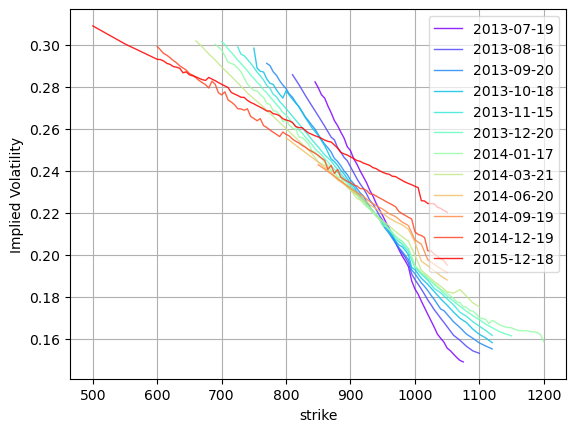

In [12]:
expiries = query_expirations(as_of_date, underlying, dte=dte)
_, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("rainbow", len(expiries))
format_kw = {"linewidth": 1, "alpha": 0.85}
for i, expiry in enumerate(expiries):
    curve = read_vol_curve(
        as_of_date,
        underlying,
        expiry,
        delta_low,
        delta_high
    )
    (
        curve
        .sort_index()
        .plot(
            ax=ax,
            y="iv",
            label=expiry.strftime("%Y-%m-%d"),
            grid=True,
            color=cmap(i),
            **format_kw
        )
    )
ax.set_ylabel("Implied Volatility")
ax.legend(loc="upper right", framealpha=0.7)